In [1]:
import sys
sys.path.append('../')

import numpy as np
np.random.seed(314159)

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import parameter_tuning
import plot_boundary
import analysis_functions as af

from metric_functions import compute_accuracy, compute_auc_from_scores
from kernel_SVM_functions import rbf_kernel
from classifiers import QUBOSoftMarginClassifier, SoftMarginKernelClassifier

In [2]:
train_size = 0.4
filename = 'synth_0.2.csv'

run_qsvms = False
run_csvm = False

In [3]:
data = np.loadtxt(f'../synth_data/{filename}', delimiter = ',')

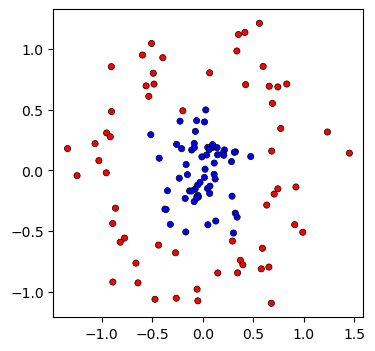

In [4]:
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.scatter(data[:, 0], data[:, 1], c = data[:, 2], cmap = 'bwr', s = 20, edgecolors = 'black', linewidths = 0.5)
plt.show()

In [5]:
X = data[:, :-1]
t = data[:, -1]

X_train, X_test, t_train, t_test = train_test_split(X, t, train_size = train_size, shuffle = True, stratify = t)

t_train = t_train.reshape(-1, 1)
t_test = t_test.reshape(-1, 1)

## QSVMs Calibration

In [6]:
B_values = [2, 3, 5, 10]
K_values = [2, 3, 4]
R_values = [0, 1, 3, 5]
gamma_values = [2 ** i for i in range(-3, 3)]
kernel_func = rbf_kernel
#This results in a matrix with shape (4, 2, 4, 7)

if run_qsvms:

    accuracy_results, auroc_results, times = parameter_tuning.tune_qsvm_parameters(X_train, t_train, B_values, K_values, R_values, gamma_values, kernel_func, num_models = 30)

    np.save(f'../results/QUBO-{filename}-accuracy', accuracy_results)
    np.save(f'../results/QUBO-{filename}-auroc', auroc_results)
    np.save(f'../results/QUBO-{filename}-time', times)


Progress:   0%|          | 0/288 [00:00<?, ?it/s]

Progress:   1%|          | 3/288 [00:25<40:36,  8.55s/it]


KeyboardInterrupt: 

## cSVM Calibration

In [ ]:
C_values = [2 ** i for i in range(0, 7)]
gamma_values = [2 **i for i in range(-3, 3)]
kernel_func = rbf_kernel

if run_csvm:

    accuracy_results, auroc_results, times = parameter_tuning.tune_csvm_parameters(X_train, t_train, C_values, gamma_values, kernel_func)

    np.save(f'../results/kSVM-{filename}-accuracy', accuracy_results)
    np.save(f'../results/kSVM-{filename}-auroc', auroc_results)
    np.save(f'../results/kSVM-{filename}-time', times)


## Load data from files

In [ ]:
qSVM_accuracy = np.load(f'../results/QUBO-{filename}-accuracy.npy')
qSVM_auroc = np.load(f'../results/QUBO-{filename}-auroc.npy')

cSVM_accuracy = np.load(f'../results/kSVM-{filename}-accuracy.npy')
cSVM_auroc = np.load(f'../results/kSVM-{filename}-auroc.npy')

In [ ]:
qSVM_accuracy.shape, cSVM_accuracy.shape

((4, 3, 4, 6), (7, 6))

## Best performance

In [ ]:
print(f'cSVM best accuracy {np.max(cSVM_accuracy[:, 1: ])} \n cSVM best auroc {np.max(cSVM_auroc[:, 1: ])} \n')
print(f'qSVM best accuracy {np.max(qSVM_accuracy)} \n qSVM best auroc {np.max(qSVM_auroc)} \n')

cSVM best accuracy 1.0 
 cSVM best auroc 1.0 

qSVM best accuracy 0.9441666666666666 
 qSVM best auroc 0.9955555555555555 



## Best QSVMs models

In [ ]:
#Finds the top 20 QSVMs hyper-parameters based on cross validation AUROC score 

val_list = [B_values, K_values, R_values, gamma_values]
model_indices = af.find_best(qSVM_auroc, 20)
top_qsvms_models = [af.get_params(val_list, model_indices[i]) for i in range(len(model_indices))]

In [ ]:
#Trains 50 of each of the top QSVMs models on the entire training set and tests them on the test set
#The AUROC and accuracy is averaged across the 50 models for an accurate score.

tp_acc_mean = []
tp_acc_std = []

tp_auc_mean = []
tp_auc_std = []

kernel_func = rbf_kernel
n = 50

#Averaging the accuracy and auc for each parameter set over 50 models
for i, model_parameters in enumerate(top_qsvms_models):

    accuracy = []
    auroc = []

    for j in range(n):
        
        qsmc = QUBOSoftMarginClassifier(model_parameters[0], model_parameters[1], model_parameters[2], kernel_func, model_parameters[3])
        qsmc = qsmc.make_QUBO_problem(X_train, t_train).fit(X_train, t_train)
        scores = qsmc.decision_function(X_test)
        preds = qsmc.predict(X_test)
        
        accuracy.append(compute_accuracy(preds, t_test))
        auroc.append(compute_auc_from_scores(scores, t_test))

    tp_acc_mean.append(np.mean(accuracy))
    tp_acc_std.append(np.std(accuracy))

    tp_auc_mean.append(np.mean(auroc))
    tp_auc_std.append(np.std(auroc))

In [ ]:
sort_index = np.argsort(-np.array(tp_auc_mean))

top_models = np.array(top_qsvms_models)[sort_index]

tp_acc_mean = np.array(tp_acc_mean)[sort_index]
tp_acc_std = np.array(tp_acc_std)[sort_index]

tp_auc_mean = np.array(tp_auc_mean)[sort_index]
tp_auc_std = np.array(tp_auc_std)[sort_index]

In [ ]:
print(np.array(top_qsvms_models))

[[2 4 0 4]
 [3 2 5 4]
 [2 3 0 4]
 [2 3 0 2]
 [2 4 3 4]
 [2 4 5 4]
 [2 4 3 2]
 [2 3 5 2]
 [2 2 5 2]
 [2 2 5 4]
 [2 3 3 4]
 [2 3 3 2]
 [2 3 5 4]
 [2 4 1 2]
 [2 2 3 4]
 [2 3 1 4]
 [5 3 5 4]
 [3 3 5 4]
 [3 4 5 4]
 [2 4 0 2]]


In [ ]:
print(tp_auc_mean)

[0.99776235 0.99756173 0.99734568 0.99716049 0.9970679  0.99705247
 0.99705247 0.99682099 0.9967284  0.99640432 0.9962963  0.9962963
 0.99626543 0.99623457 0.99595679 0.99574074 0.99535494 0.99509259
 0.99453704 0.99220679]


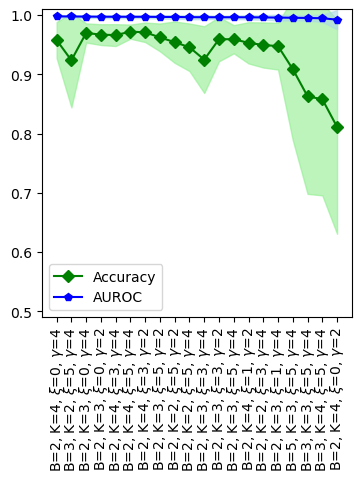

In [ ]:
fig, ax = plt.subplots(figsize = (4, 4))

af.plot_top_models(top_qsvms_models, np.array([tp_acc_mean, tp_acc_std]), np.array([tp_auc_mean, tp_auc_std]), fig = fig, ax = ax)
plt.savefig('../plots/synth-0.2_qsvms_plot.png', dpi = 256)
plt.show()

## Boundary plots

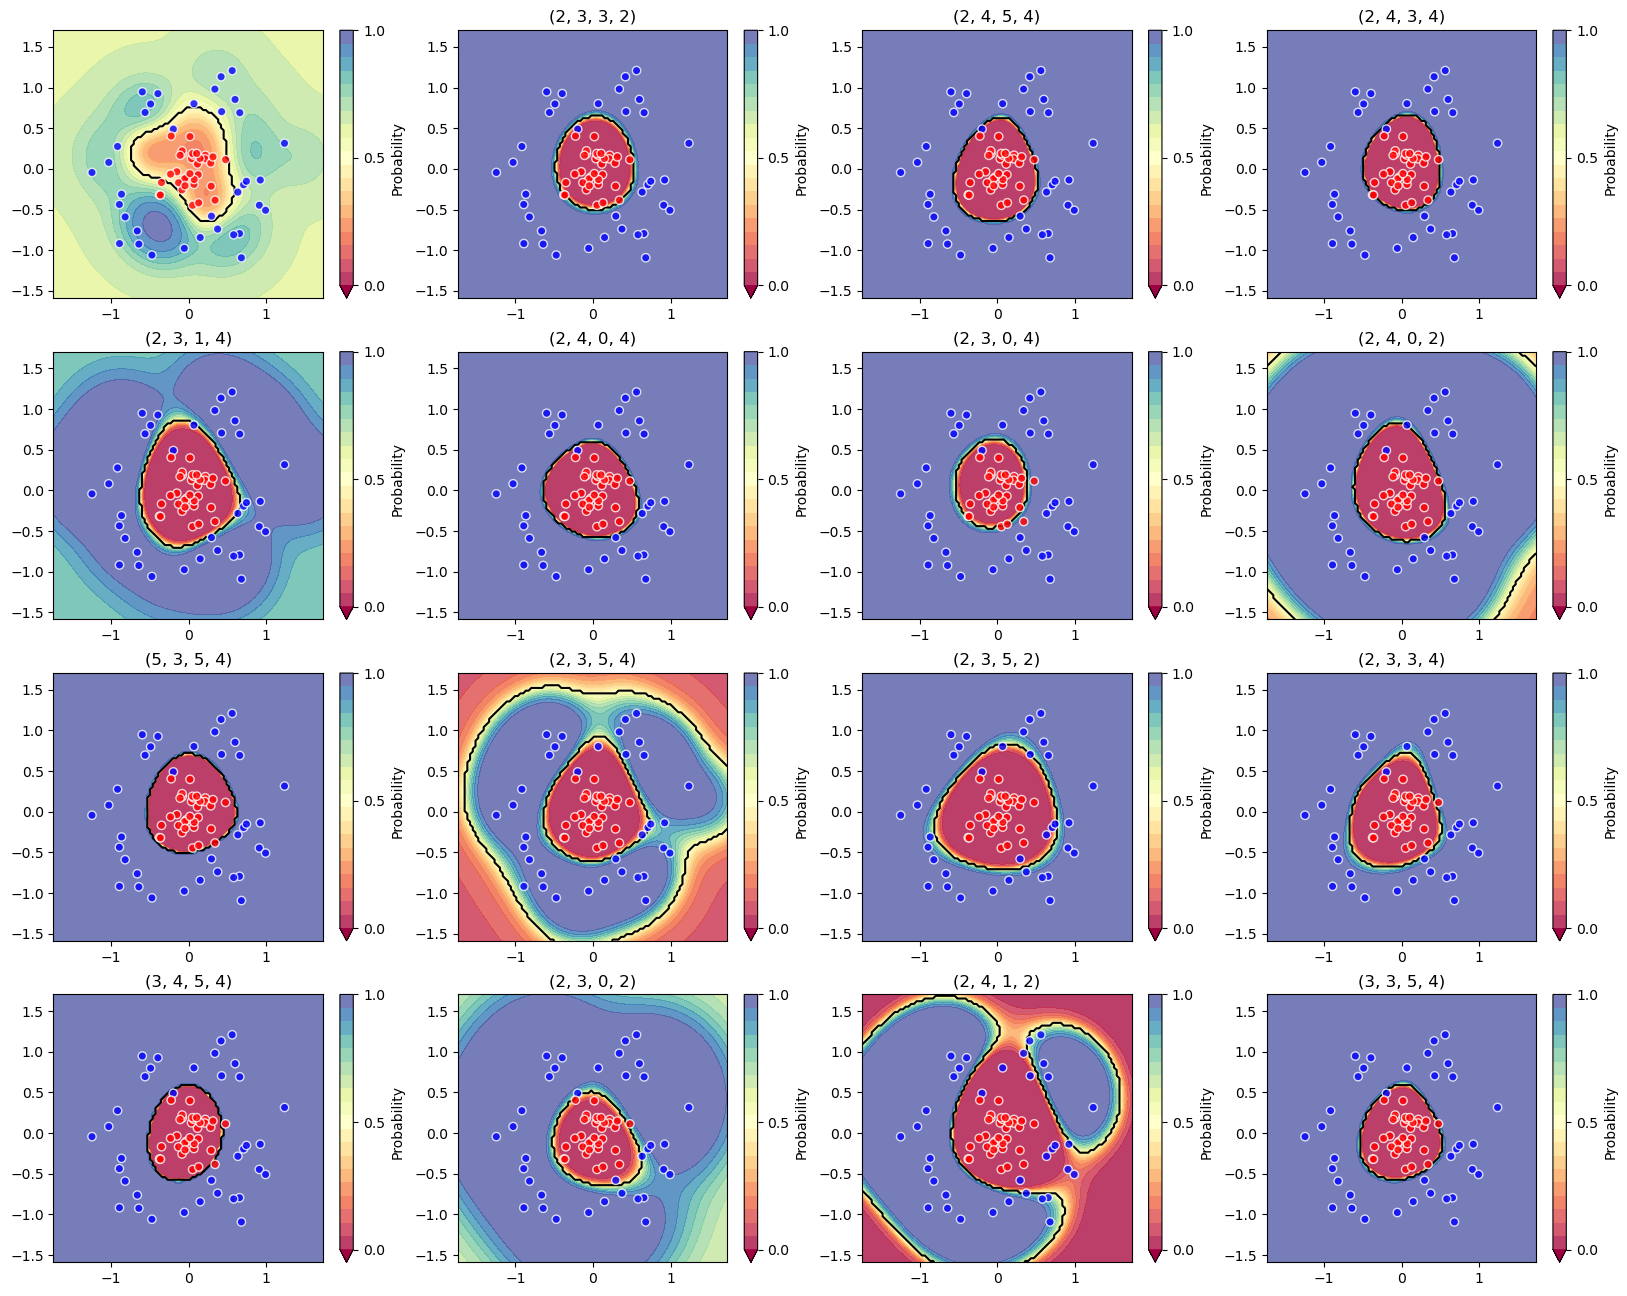

In [ ]:
fig, ax = plt.subplots(4, 4, figsize = (20, 16))

csvm = SoftMarginKernelClassifier(3, kernel_func, 6)
csvm = csvm.fit(X_train, t_train)
plot_boundary.plot(X_test, t_test, csvm, contour_func = 'predict_proba', colorbar = True, fig = fig, ax = ax[0, 0])

for i in range(4):
    for j in range(4):
        if i + j == 0:
            continue
        else:
            index = 4 * i + j
            B = top_models[index][0]
            K = top_models[index][1]
            R = top_models[index][2]
            gamma = top_models[index][3]
            
            clf = QUBOSoftMarginClassifier(B, K, R, kernel_func, gamma)
            clf = clf.make_QUBO_problem(X_train, t_train).fit(X_train, t_train)
            plot_boundary.plot(X_test, t_test, clf, contour_func = 'predict_proba', colorbar = True, fig = fig, ax = ax[i, j])

            ax[i, j].set_title(f'({B}, {K}, {R}, {gamma})')
    
plt.show()

## Best cSVM models

In [ ]:
#Finding the 5 cSVM models which performed best in the calibration phase.

val_list = [C_values, gamma_values]
model_indices = af.find_best(cSVM_auroc, 5)
top_csvm_models = [af.get_params(val_list, model_indices[i]) for i in range(len(model_indices))]

In [ ]:
np.unravel_index(np.argsort(-cSVM_auroc.flatten())[:5], cSVM_auroc.shape)

(array([6, 3, 4, 6, 5]), array([5, 5, 5, 4, 3]))

In [ ]:
#Each of the top 5 csvm models are trained on the full training set and tested on the test set.
#The AUROC and accuracy are the final scores for that dataset.

final_auroc = []
final_accuracy = []

for c, g in top_csvm_models:

    clf = SoftMarginKernelClassifier(c, kernel_func, g)
    clf = clf.fit(X_train, t_train)

    preds = clf.predict(X_test)
    scores = clf.decision_function(X_test)

    final_auroc.append(compute_auc_from_scores(scores, t_test))
    final_accuracy.append(compute_accuracy(preds, t_test))

In [ ]:
sort_index = np.argsort(-np.array(final_auroc))

top_csvm_models = np.array(top_csvm_models)[sort_index]
final_auroc = np.array(final_auroc)[sort_index]
final_accuracy = np.array(final_accuracy)[sort_index]

In [ ]:
final_auroc

array([0.9992284 , 0.99845679, 0.99845679, 0.99845679, 0.99845679])

In [ ]:
print(np.array(top_csvm_models))

[[32  1]
 [ 8  4]
 [16  2]
 [16  4]
 [32  2]]
